In [1]:
import cv2
import numpy as np
img = cv2.imread("snake1.jpg")

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_ , tresh = cv2.threshold(gray,np.mean(gray), 255, cv2.THRESH_BINARY_INV)

# GET CONTOURS

contours , hierarchy = cv2.findContours(tresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

print(len(contours))

# lets get the bigger area

cnt = sorted(contours, key=cv2.contourArea)[-1]


mask = np.zeros( (480, 640), dtype="uint8" )
print(type(mask))
print(mask.shape)

maskedRed = cv2.drawContours(mask,[cnt] , -1 , (0 , 0 , 255), -1)
maskedFinal = cv2.drawContours(mask,[cnt] , -1 , (255 , 255 , 255), -1)

finalImage = cv2.bitwise_and(img, img, mask=maskedFinal)

cv2.imshow("Original", img)
cv2.imshow("maskedFinal", finalImage)

cv2.imwrite("finalImage.jpg",finalImage)

cv2.waitKey(0)

cv2.destroyAllWindows()

138
<class 'numpy.ndarray'>
(480, 640)


(480, 640)
(480, 640)
float64
38


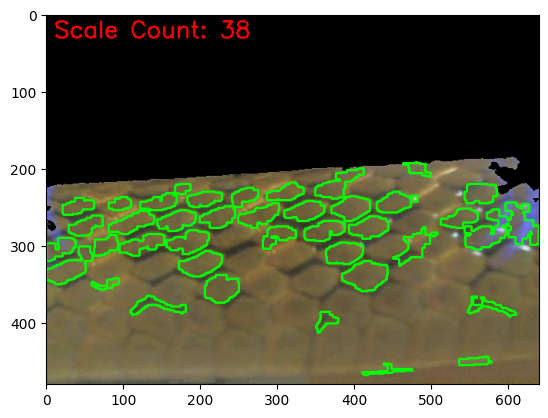

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def Canny_edge_detector(gimg,thlow = None,thhigh = None):
    gimg = cv2.GaussianBlur(gimg,(5,5),1.4)

    #2 - Compute Gradient
    gradient_x = cv2.Sobel(np.float32(gimg),cv2.CV_64F, 1, 0, 3)
    gradient_y = cv2.Sobel(np.float32(gimg),cv2.CV_64F, 0, 1, 3)

    #3- Compute Magnitude and Direction
    mag,dir = cv2.cartToPolar(gradient_x,gradient_y,angleInDegrees=True)

    # Setting minimum and maximum thresholds for Hysterisis Thresholding
    mag_max = np.max(mag)
    if not thlow: thlow = mag_max * 0.1
    if not thhigh: thhigh = mag_max  * 0.5

    height, width = gimg.shape

    #For every pixel:
    for i_x in range(width):
        for i_y in range(height):
            grad_ang = dir[i_y, i_x]
            grad_ang = abs(grad_ang - 180) if abs(grad_ang) > 180 else abs(grad_ang)

            # X-axis
            if grad_ang <= 22.5:
                neighb_1_x, neighb_1_y = i_x - 1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

                # top right (diagonal-1)
            elif grad_ang > 22.5 and grad_ang <= (22.5 + 45):
                neighb_1_x, neighb_1_y = i_x - 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1

                # Y-axis
            elif grad_ang > (22.5 + 45) and grad_ang <= (22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y - 1
                neighb_2_x, neighb_2_y = i_x, i_y + 1

                # top left (diagonal-2) direction
            elif grad_ang > (22.5 + 90) and grad_ang <= (22.5 + 135):
                neighb_1_x, neighb_1_y = i_x - 1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y - 1

                # Now it restarts the cycle
            elif grad_ang > (22.5 + 135) and grad_ang <= (22.5 + 180):
                neighb_1_x, neighb_1_y = i_x - 1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

                # Non-maximum suppression step
            if width > neighb_1_x >= 0 and height > neighb_1_y >= 0:
                if mag[i_y, i_x] < mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x] = 0
                    continue

            if width > neighb_2_x >= 0 and height > neighb_2_y >= 0:
                if mag[i_y, i_x] < mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x] = 0

    weak_ids = np.zeros_like(gimg)
    strong_ids = np.zeros_like(gimg)
    ids = np.zeros_like(gimg)

    # Hysterisis thresholding step
    for i_x in range(width):
        for i_y in range(height):

            grad_mag = mag[i_y, i_x]

            if grad_mag < thlow:
                mag[i_y, i_x] = 0
            elif thhigh > grad_mag >= thlow:
                ids[i_y, i_x] = 1
            else:
                ids[i_y, i_x] = 2

    return mag

snake = cv2.imread("finalImage.jpg")
snake1 = cv2.imread("finalImage.jpg",0)

ret, threshold_image = cv2.threshold(snake1, 127, 255,cv2.THRESH_TRUNC)


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(threshold_image)

cv2.imshow("Enhanced Image", enhanced)

canny_img = Canny_edge_detector(enhanced)

print(canny_img.shape)

kernel1 = np.ones((7,7), np.uint8)
kernel2 = np.ones((9,9), np.uint8)

img_morph = cv2.dilate(canny_img, kernel1, iterations=1)
img_morph = cv2.erode(img_morph, kernel2, iterations=1)

cv2.imshow("After Morphological Operations",img_morph)

cv2.waitKey(0)
cv2.destroyAllWindows()

print(img_morph.shape)
print(img_morph.dtype)

ret, complimented_img = cv2.threshold(img_morph, 15, 255, cv2.THRESH_BINARY)
ret, complimented_img = cv2.threshold(complimented_img, 127, 255, cv2.THRESH_BINARY_INV)
cv2.imshow("Reverse",complimented_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
complimented_img = cv2.convertScaleAbs(complimented_img)

contours, _ = cv2.findContours(complimented_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Initialize a count for the number of scales

contours = list(contours)
i= 0
sum_area = 0
for contour in contours:
    area = cv2.contourArea(contour)
    sum_area += area
avg_area = sum_area/len(contours)

scale_count = 0
while i<len(contours):
    area = cv2.contourArea(contours[i])
    if area>avg_area*0.09 and area<avg_area*1.5:
        scale_count += 1
        i += 1
    else:
        contours = contours[:i] + contours[i+1:]
print(len(contours))
cv2.waitKey(0)
cv2.destroyAllWindows()
# Display the image with the detected contours
cv2.drawContours(snake, tuple(contours), -1, (0, 255, 0), 2)  # Draw all contours in green
cv2.waitKey(0)
cv2.destroyAllWindows()

#scale_count = len(contours)
cv2.putText(snake, f'Scale Count: {scale_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
snake1 = cv2.cvtColor(snake1,cv2.COLOR_BGR2RGB)
snake = cv2.cvtColor(snake,cv2.COLOR_BGR2RGB)
plt.imshow(snake)
# Display the result
cv2.imshow('Snake Scales Count', snake1)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
import cv2
import numpy as np
img = cv2.imread("snake1.jpg")

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_ , tresh = cv2.threshold(gray,np.mean(gray), 255, cv2.THRESH_BINARY_INV)
cv2.imwrite("SNAKE1 INVERSE BINARY THRESHOLDING.jpg",tresh)

# GET CONTOURS
contours , hierarchy = cv2.findContours(tresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

# lets get the bigger area
cnt = sorted(contours, key=cv2.contourArea)[-1]

mask = np.zeros( (480, 640), dtype="uint8" )
print(type(mask))
print(mask.shape)

maskedRed = cv2.drawContours(mask,[cnt] , -1 , (0 , 0 , 255), -1)
maskedFinal = cv2.drawContours(mask,[cnt] , -1 , (255 , 255 , 255), -1)

finalImage = cv2.bitwise_and(img, img, mask=maskedFinal)

cv2.imshow("Original", img)
cv2.imshow("maskedFinal", finalImage)
cv2.imwrite("SNAKE1 finalImage.jpg",finalImage)

cv2.waitKey(0)

cv2.destroyAllWindows()

138
<class 'numpy.ndarray'>
(480, 640)


39.173715677734734 195.86857838867365
(480, 640)
(480, 640)
float64
56


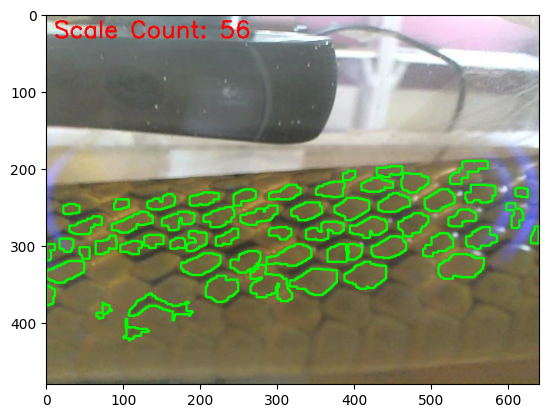

In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def Canny_edge_detector(gimg,thlow = None,thhigh = None):
    gimg = cv2.GaussianBlur(gimg,(5,5),1.4)

    #2 - Compute Gradient
    gradient_x = cv2.Sobel(np.float32(gimg),cv2.CV_64F, 1, 0, 3)
    gradient_y = cv2.Sobel(np.float32(gimg),cv2.CV_64F, 0, 1, 3)

    #3- Compute Magnitude and Direction
    mag,dir = cv2.cartToPolar(gradient_x,gradient_y,angleInDegrees=True)

    # Setting minimum and maximum thresholds for Hysterisis Thresholding
    mag_max = np.max(mag)
    if not thlow: thlow = mag_max * 0.1
    if not thhigh: thhigh = mag_max  * 0.5
    print(thlow,thhigh)
    height, width = gimg.shape

    #For every pixel:
    for i_x in range(width):
        for i_y in range(height):
            grad_ang = dir[i_y, i_x]
            grad_ang = abs(grad_ang - 180) if abs(grad_ang) > 180 else abs(grad_ang)

            # X-axis
            if grad_ang <= 22.5:
                neighb_1_x, neighb_1_y = i_x - 1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

                # top right (diagonal-1)
            elif grad_ang > 22.5 and grad_ang <= (22.5 + 45):
                neighb_1_x, neighb_1_y = i_x - 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1

                # Y-axis
            elif grad_ang > (22.5 + 45) and grad_ang <= (22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y - 1
                neighb_2_x, neighb_2_y = i_x, i_y + 1

                # top left (diagonal-2) direction
            elif grad_ang > (22.5 + 90) and grad_ang <= (22.5 + 135):
                neighb_1_x, neighb_1_y = i_x - 1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y - 1

                # Now it restarts the cycle
            elif grad_ang > (22.5 + 135) and grad_ang <= (22.5 + 180):
                neighb_1_x, neighb_1_y = i_x - 1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

                # Non-maximum suppression step
            if width > neighb_1_x >= 0 and height > neighb_1_y >= 0:
                if mag[i_y, i_x] < mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x] = 0
                    continue

            if width > neighb_2_x >= 0 and height > neighb_2_y >= 0:
                if mag[i_y, i_x] < mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x] = 0

    weak_ids = np.zeros_like(gimg)
    strong_ids = np.zeros_like(gimg)
    ids = np.zeros_like(gimg)

    # Hysterisis thresholding step
    for i_x in range(width):
        for i_y in range(height):

            grad_mag = mag[i_y, i_x]

            if grad_mag < thlow:
                mag[i_y, i_x] = 0
            elif thhigh > grad_mag >= thlow:
                ids[i_y, i_x] = 1
            else:
                ids[i_y, i_x] = 2

    return mag
img = cv2.imread("snake1.jpg")
snake = cv2.imread("finalImage.jpg")
snake1 = cv2.imread("finalImage.jpg",0)

ret, threshold_image = cv2.threshold(snake1, 127, 255,cv2.THRESH_TRUNC)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(threshold_image)

cv2.imshow("Enhanced Image", enhanced)
cv2.imwrite("SNAKE1 Sharpened Image.jpg", enhanced)

canny_img = Canny_edge_detector(enhanced)
print(canny_img.shape)
cv2.imwrite("SNAKE1 Canny Image.jpg",canny_img)

kernel1 = np.ones((9,9), np.uint8)
kernel2 = np.ones((9,9), np.uint8)

img_morph = cv2.dilate(canny_img, kernel1, iterations=1)
img_morph = cv2.erode(img_morph, kernel2, iterations=1)

cv2.imshow("After Morphological Operations",img_morph)
cv2.imwrite("SNAKE1 After Morphological Operations.jpg",img_morph)

cv2.waitKey(0)
cv2.destroyAllWindows()

print(img_morph.shape)
print(img_morph.dtype)

ret, complimented_img = cv2.threshold(img_morph, 15, 255, cv2.THRESH_BINARY)
ret, complimented_img = cv2.threshold(complimented_img, 127, 255, cv2.THRESH_BINARY_INV)
cv2.imshow("Reverse",complimented_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
complimented_img = cv2.convertScaleAbs(complimented_img)
cv2.imwrite("SNAKE1 Thresholding.jpg",complimented_img)

contours, _ = cv2.findContours(complimented_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Initialize a count for the number of scales

contours = list(contours)
i= 0
sum_area = 0
for contour in contours:
    area = cv2.contourArea(contour)
    sum_area += area
avg_area = sum_area/len(contours)

scale_count = 0
while i<len(contours):
    area = cv2.contourArea(contours[i])
    if area>avg_area*0.09 and area<avg_area*1.5:
        scale_count += 1
        i += 1
    else:
        contours = contours[:i] + contours[i+1:]
print(len(contours))
cv2.waitKey(0)
cv2.destroyAllWindows()
# Display the image with the detected contours
cv2.drawContours(img, tuple(contours), -1, (0, 255, 0), 2)  # Draw all contours in green
cv2.waitKey(0)
cv2.destroyAllWindows()

#scale_count = len(contours)
cv2.putText(img, f'Scale Count: {scale_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
snake1 = cv2.cvtColor(snake1,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
# Display the result
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
cv2.imshow('Snake Scales Count', img)
cv2.imwrite('SNAKE1 Snake Scales Count.jpg', img)

cv2.waitKey(0)
cv2.destroyAllWindows()